В компании, которая разрабатывает приложение для обработки и оформления фотографий в формате Stories был проведен A/B тест: тестовой группе предлагалась новая модель оплаты коллекций шаблонов, контрольной – старая механика. Основная задача: проанализировать итоги эксперимента и решить, нужно ли выкатывать новую модель на остальных пользователей.

In [1]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms

Данные в 3-х файлах:

In [2]:
path1 = 'https://stepik.org/media/attachments/lesson/426730/active_users.csv'
path2 = 'https://stepik.org/media/attachments/lesson/426730/groups.csv'
path3 = 'https://stepik.org/media/attachments/lesson/426730/purchases.csv'

In [3]:
active_users = pd.read_csv(path1)
groups = pd.read_csv(path2)
purchases = pd.read_csv(path3)

#### 1. Данные по активным пользователям на период экксперимента `active_users`:

In [4]:
active_users.head()

,user_id,country,platform,sex
0,8029,Russia,ios,male
1,1735,Sweden,ios,male
2,7697,Russia,android,male
3,1421,Sweden,android,female
4,1704,Russia,ios,male


In [5]:
active_users.dtypes

user_id      int64
country     object
platform    object
sex         object
dtype: object

In [6]:
active_users.describe(include = 'all')

,user_id,country,platform,sex
count,8341.000000,8341,8341,8341
unique,NaN,2,2,2
top,NaN,Russia,android,male
freq,NaN,5407,4621,4196
mean,4170.000000,NaN,NaN,NaN
std,2407.983631,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN
25%,2085.000000,NaN,NaN,NaN
50%,4170.000000,NaN,NaN,NaN
75%,6255.000000,NaN,NaN,NaN


Поcмотрим на сводные данные по активным пользователям (пока нет информации о распределении по группам А и В):

In [7]:
active_users.pivot_table(values = 'user_id', columns = ['country', 'sex'], index = 'platform', aggfunc = 'count')

country  Russia       Sweden     
sex      female  male female male
platform                         
android    1477  1511    824  809
ios        1187  1232    657  644

Общее количество активных пользователей на период эксперимента:

In [8]:
active_users.user_id.nunique()

8341

#### 2. Данные по общему распределению пользователей на группы А и В `groups`:

In [9]:
groups.dtypes

user_id     int64
group      object
dtype: object

In [10]:
groups.head()

,user_id,group
0,9149,B
1,9150,B
2,9151,A
3,9152,B
4,9153,B


Общее число пользователей, в системе сплитования:

In [11]:
groups.user_id.nunique()

74576

Разделение по группам в %:

In [12]:
groups.group.value_counts(normalize = True).mul(100).round(1)

B    80.3
A    19.7
Name: group, dtype: float64

Разделение по группам в натуральном выражении:

In [13]:
groups.group.value_counts()

B    59883
A    14693
Name: group, dtype: int64

#### 3. Данные по покупкам клиентов `purchases`:

In [14]:
purchases.head()

,user_id,revenue
0,4412,1000.0
1,9000,701.0
2,9001,700.0
3,9002,702.0
4,5790,1002.0


In [15]:
purchases.describe()

,user_id,revenue
count,541.000000,541.000000
mean,5383.439926,1069.754159
std,3036.517601,762.702202
min,62.000000,207.000000
25%,2557.000000,302.000000
50%,5530.000000,850.000000
75%,9013.000000,1909.000000
max,9148.000000,4660.000000


In [16]:
purchases.dtypes

user_id      int64
revenue    float64
dtype: object

Количество покупателей на период эксперимента:

In [17]:
purchases.user_id.nunique()

541

In [18]:
purchases.revenue.sum()

578737.0

Итак: 
* общее число пользователей в системе сплитования эксперимента - 74 576 человек, 
* число активных пользователей - 8341 чел., 
* число пользователей, совершивших покупки - 541 чел.
* соотношение между А контрольной и В тестовой группами: А - 19,7%, В - 80,3 % (нужно проверить баланс групп в данных с активными пользователями, учитывая их пол, платформу, страну проживания)

--------------------------------------

### Проверка распределения пользователей по группам эксперимента в зависимотсти от пола, страны и платформы.
Есть две категориальные переменные → нужен критерий хи-квадрат
- $H_0$: взаимосвязи между выборками нет 
- $H_1$: взаимосвязь есть

In [19]:
def check_hypotesis(p_value_test, probability = 0.95):
    '''
    функция для проверки достоверности гипотез по полученному p-value
    при заданном уровне значимости 0,95
    '''
    alpha = 1.0 - probability
    if p_value_test <= alpha:
        return 'Отклоняем H0'
    else:
        return 'Не отклоняем H0'
    
def relations_control(data, segment, probability = 0.95):
    '''
    функция для оценки значимости различий между сегментами на базе критерия хи-квадрат
    '''
    df = pd.crosstab(data.group, data[segment])
    stat, p, dof, expected = stats.chi2_contingency(df)
    
    return check_hypotesis(p, probability)

In [20]:
active_by_group = active_users.merge(groups)

Проверка корректности разделения групп по полу:

In [21]:
relations_control(active_by_group,'sex')

'Не отклоняем H0'

Проверка корректности разделения групп по платформе устройства:

In [22]:
active_by_group.groupby('platform').group.value_counts(normalize = True).mul(100).round(1)

platform  group
android   B        82.0
          A        18.0
ios       B        81.1
          A        18.9
Name: group, dtype: float64

In [23]:
relations_control(active_by_group, 'platform')

'Не отклоняем H0'

Проверка корректности разделения групп по стране пользователя:

In [24]:
relations_control(active_by_group, 'country')

'Отклоняем H0'

In [25]:
def relations(data, segment, probability = 0.95):
    '''
    функция оценки значимости различий с помощью критерия хи-квалрат
    по таблице сопряженности
    '''
    df = pd.crosstab(data.group, data[segment])
    return df

In [26]:
relations(active_by_group, 'country')

country,Russia,Sweden
group,,
A,915,623
B,4492,2311


In [27]:
active_by_group.groupby('country').group.value_counts(normalize = True).mul(100).round(1)

country  group
Russia   B        83.1
         A        16.9
Sweden   B        78.8
         A        21.2
Name: group, dtype: float64

По активным пользователям: распределение на тестовую и контрольную группы прошло корректно по полу пользователей, по платформе пользователей. По стране пользователей соотношение в группах нарушено. В целом, можно считать выборку активных пользователей репрезентативной.

-------------

Наш эксперимент - упрощение системы оплаты. Мы ждем увеличения выручки за счет:
* роста средней выручки на платящего пользователя (ARPPU)
* увеличения конверсии в покупателя 

### Проверяем гипотезу $H_0$ : распределение выручки для контрольной и тестовой группы значимо не отличаются, уровень значимости - 0.95
Для начала добавим данные о распределении по группам эксперимента в данные о покупках:

In [28]:
groups_purchases = groups.merge(purchases, on = 'user_id')
groups_purchases.head()

,user_id,group,revenue
0,9061,B,699.0
1,9036,B,300.0
2,9073,B,702.0
3,9130,B,591.0
4,9035,B,700.0


In [29]:
groups_purchases.shape

(541, 3)

Посмотрим на распределение по группам у покупателей:

In [30]:
groups_purchases.group.value_counts()

B    434
A    107
Name: group, dtype: int64

Общий доход по группам: 

In [31]:
groups_purchases.groupby('group').agg({'revenue':'sum'})

,revenue
group,
A,93162.0
B,485575.0


Средний объем выручки на клиента, фактически это ARPPU (если предположить, что данные о транзакциях клиентов могут содержать повторные покупки):

In [32]:
groups_purchases.groupby('group')\
                .agg({'revenue':'mean'})\
                .round()\
                .rename(columns = {'revenue':'ARPPU'})

,ARPPU
group,
A,871.0
B,1119.0


Построим боксплот распределения выручки по группам эксперимента:

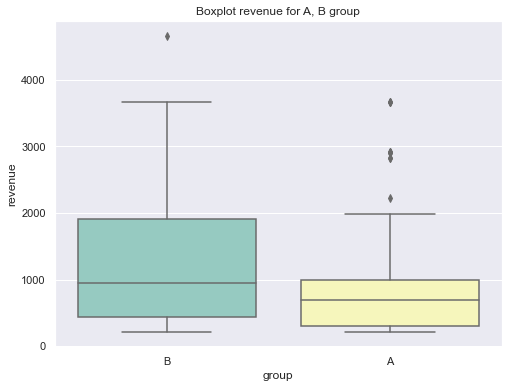

In [33]:
sns.set(rc={'figure.figsize':(8,6)})
sns.boxplot(y = 'revenue', x = 'group', data = groups_purchases, palette="Set3")
plt.title('Boxplot revenue for A, B group')
plt.show()

Дисперсия в `группе B` больше (но и размер выборки в 4 раза больше), в `группе А` много выбросов.

Разделим данные, в соответствии с группой эксперимента:

In [34]:
revenue_A = groups_purchases.query('group == "A"').revenue
revenue_B = groups_purchases.query('group == "B"').revenue

Рассчитаем доверительные интервалы для среднего ARPPU по группам:

In [35]:
low_ARPPU_A, up_ARPPU_A = sms.DescrStatsW(revenue_A).tconfint_mean()
low_ARPPU_B, up_ARPPU_B = sms.DescrStatsW(revenue_B).tconfint_mean()
print(f"ARPPU для группы А: {round(revenue_A.mean())}, доверительный интервал: {round(low_ARPPU_A)} - {round(up_ARPPU_A)}")
print(f"ARPPU для группы B: {round(revenue_B.mean())}, доверительный интервал: {round(low_ARPPU_B)} - {round(up_ARPPU_B)}")

ARPPU для группы А: 871, доверительный интервал: 714 - 1027
ARPPU для группы B: 1119, доверительный интервал: 1049 - 1189


Построим гистограммы распределения выручки по группам. Так как объемы выборок разные, то исспользуем нормализацию для возможности корректного сравнения:

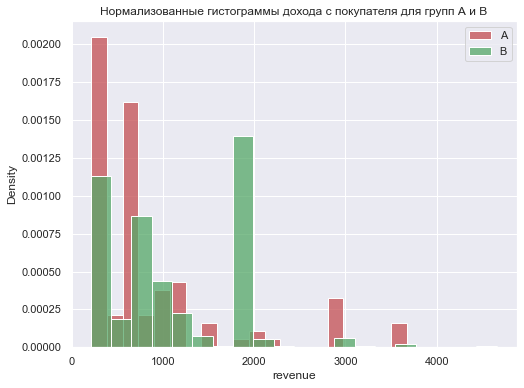

In [36]:
sns.histplot(revenue_A, stat =  "density", bins = 20, color = 'r', label = 'A',)
sns.histplot(revenue_B, stat =  "density", bins = 20, color = 'g', label = 'B')
plt.title('Нормализованные гистограммы дохода с покупателя для групп А и В')
plt.legend()
plt.show()

По гистограммам распределение выручки в группах "А" и "В" существенно отличается от нормального. Проверим нашу гипотезу $H_0$ используя тест Манна-Уитни:

In [37]:
u_statistic, p_value_mw = stats.mannwhitneyu(revenue_B, revenue_A)
f"p-уровень значимости теста Манна-Уитни: {p_value_mw:.2}"

'p-уровень значимости теста Манна-Уитни: 6.8e-05'

In [38]:
f"u-статистика теста Манна-Уитни: {u_statistic:.2}"

'u-статистика теста Манна-Уитни: 1.8e+04'

In [39]:
check_hypotesis(p_value_mw)

'Отклоняем H0'

Не смотря на отклонения распределения выручки в группах от нормального, попробую всё-таки посмотреть на результат Т-Теста. 

По графику бокс-плот дисперсии в наших группах явно отличались. Однако, воспользуемся тестом Флигнера для проверим гипотезу $H_0$ равенства дисперсий распределения выручки в группах А и В:

In [40]:
fligner_statistic,p_value_fligner = stats.fligner(revenue_B, revenue_A)

In [41]:
f"p-value Fligner test:{p_value_fligner}"

'p-value Fligner test:0.002192058845916346'

In [42]:
check_hypotesis(p_value_fligner)

'Отклоняем H0'

Выборки независимые, дисперсии не равны, применяем T-тест Уэлча. Гипотеза $H_0$: средняя выручка в группах A и В статистически значимо не отличается

In [43]:
t_statistic, p_value_tt = stats.ttest_ind(revenue_B, revenue_A, equal_var = False)

In [44]:
f"p-value t-test:{p_value_tt}"

'p-value t-test:0.004723038405412964'

In [45]:
check_hypotesis(p_value_fligner)

'Отклоняем H0'

### Вывод:
Проведены исследования влияния новой системы оплаты на показатели выручки. По результатам теста Манна-Уитни данные распределения статистически значимо отличаются в контрольной и тестовой группах покупателей. 
Примененный Т-тест (модификация Уэлча) так же подтвердил наличие статистически значимых отличий ARPPU для контрольной и тестовой групп. 
* ARPPU для группы А: 871.0, доверительный интервал: 714.0 - 1027.0 (уровень значимости 95%)
* ARPPU для группы B: 1119.0, доверительный интервал: 1049.0 - 1189.0 (уровень значимости 95%)


Среднее значение выручки на пользователя выросло на 28,5%

### Проверяем гипотезу $H_0$: соотношение покупающих пользователей для активных пользователей тестовой и контрольных групп не изменилась

К датафрейму с активными пользователями и группами эксперимента `active_by_group` добавим данные о покупках:

In [46]:
ab_test_users = active_by_group.merge(purchases, how = 'left', on = 'user_id')
ab_test_users.revenue.fillna(0,inplace = True)

ab_test_users.head()

,user_id,country,platform,sex,group,revenue
0,8029,Russia,ios,male,B,0.0
1,1735,Sweden,ios,male,B,0.0
2,7697,Russia,android,male,B,0.0
3,1421,Sweden,android,female,B,0.0
4,1704,Russia,ios,male,B,0.0


Введем колонку со статусом была ли покупка у пользователя или нет:

In [47]:
ab_test_users['pay_status'] = ab_test_users.revenue.apply(lambda x: 1 if x>0 else 0)
ab_test_users.head()

,user_id,country,platform,sex,group,revenue,pay_status
0,8029,Russia,ios,male,B,0.0,0
1,1735,Sweden,ios,male,B,0.0,0
2,7697,Russia,android,male,B,0.0,0
3,1421,Sweden,android,female,B,0.0,0
4,1704,Russia,ios,male,B,0.0,0


In [48]:
relations(ab_test_users, 'pay_status')

pay_status,0,1
group,,
A,1460,78
B,6489,314


In [49]:
relations_control(ab_test_users, 'pay_status')

'Не отклоняем H0'

### Вывод
Нет оснований считать, что соотношение покупающих пользователей для активных пользователей тестовой и контрольных групп  изменилось.

### Финальный вывод:
С учетом того, что средний объем выручки на платящего пользователя вырос при том же соотношении покупающих пользователей (среди активных клиентов), есть все основания для введения новой системы оплаты для всех пользователей приложения.
